<a href="https://colab.research.google.com/github/kchabin/langchain-study/blob/main/LCEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LCEL을 사용하여 간단한 LLM 애플리케이션 구축하기
영어에서 다른 언어로 텍스트를 번역하는 애플리케이션

- 언어 모델 사용
- PromptTemplates 및 OutputParsers 사용
- LangChain Expression Language(LCEL)를 사용하여 컴포넌트 연결하기
- LangSmith를 사용한 애플리케이션 디버깅 및 추적
- LangServe로 배포하기

## LangChain 설치하기

In [ ]:
%pip install langchain

## LangSmith
 > LLM 애플리케이션 개발, 모니터링 및 테스트 를 위한 플랫폼


LangChain으로 빌드하는 애플리케이션에서는 LLM을 여러번 호출한다. 애플리케이션이 점점 더 복잡해짐에 따라 chain이나 agent 내부에서 정확히 무슨 일이 일어나고 있는지 검사하기 위해 LangSmith를 활용할 수 있다.


[LangSmith 사이트](https://smith.langchain.com/)로 접속해서 회원가입
1. Setting
2. Personal
3. Create API Key
4. Personal Access Token
키 description은 임의로 설정한다.
생성된 키는 유출하지 않도록 안전한 곳에 복사한다.

In [ ]:
#주피터 노트북에서 LangSmith 키 설정 방법
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()

##언어 모델 단독 사용

사용 가능한 LLM
- OpenAI
- Anthropic -> Claude
- Azure -> Azure OpenAI
- Google
- Cohere
- NVIDIA
- FireworksAI
- AWS
- Groq
- MistralAI
- TogetherAI

개인적으로 API 키가 있는 openai 모델을 사용함.

In [ ]:
%pip install -qU langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.4 MB/s eta 0:00:00


In [ ]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass()

from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4")

··········


`ChatModel` 은 LangChain "Runnables"의 객체이다.
> Runnable : Runnable 구성 요소가 다음과 같이 동작할 수 있도록 하는 표준 인터페이스를 정의한다.
- `stream` : 응답의 청크를 스트리밍 -> 실시간 출력.
- `invoke` : 입력에 대해 체인 호출
- `batch` : 입력 목록에 대해 체인 호출 -> 일괄 처리

단순히 모델을 호출하기 위해선 `invoke` 메서드에 메시지의 리스트를 전달하면 된다.



In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

msgs = [
    SystemMessage(content="You are a helpful assistant that translates English to Korean."),
    HumanMessage(content="I love programming.")
]

model.invoke(msgs)

AIMessage(content='나는 프로그래밍을 사랑해.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 26, 'total_tokens': 39, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-c0c44ed6-0fce-4656-a530-ee2fe47810b8-0', usage_metadata={'input_tokens': 26, 'output_tokens': 13, 'total_tokens': 39, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

LangSmith TRACE를 통해서 방금 수행한 모델의 결과를 추적할 수 있다.

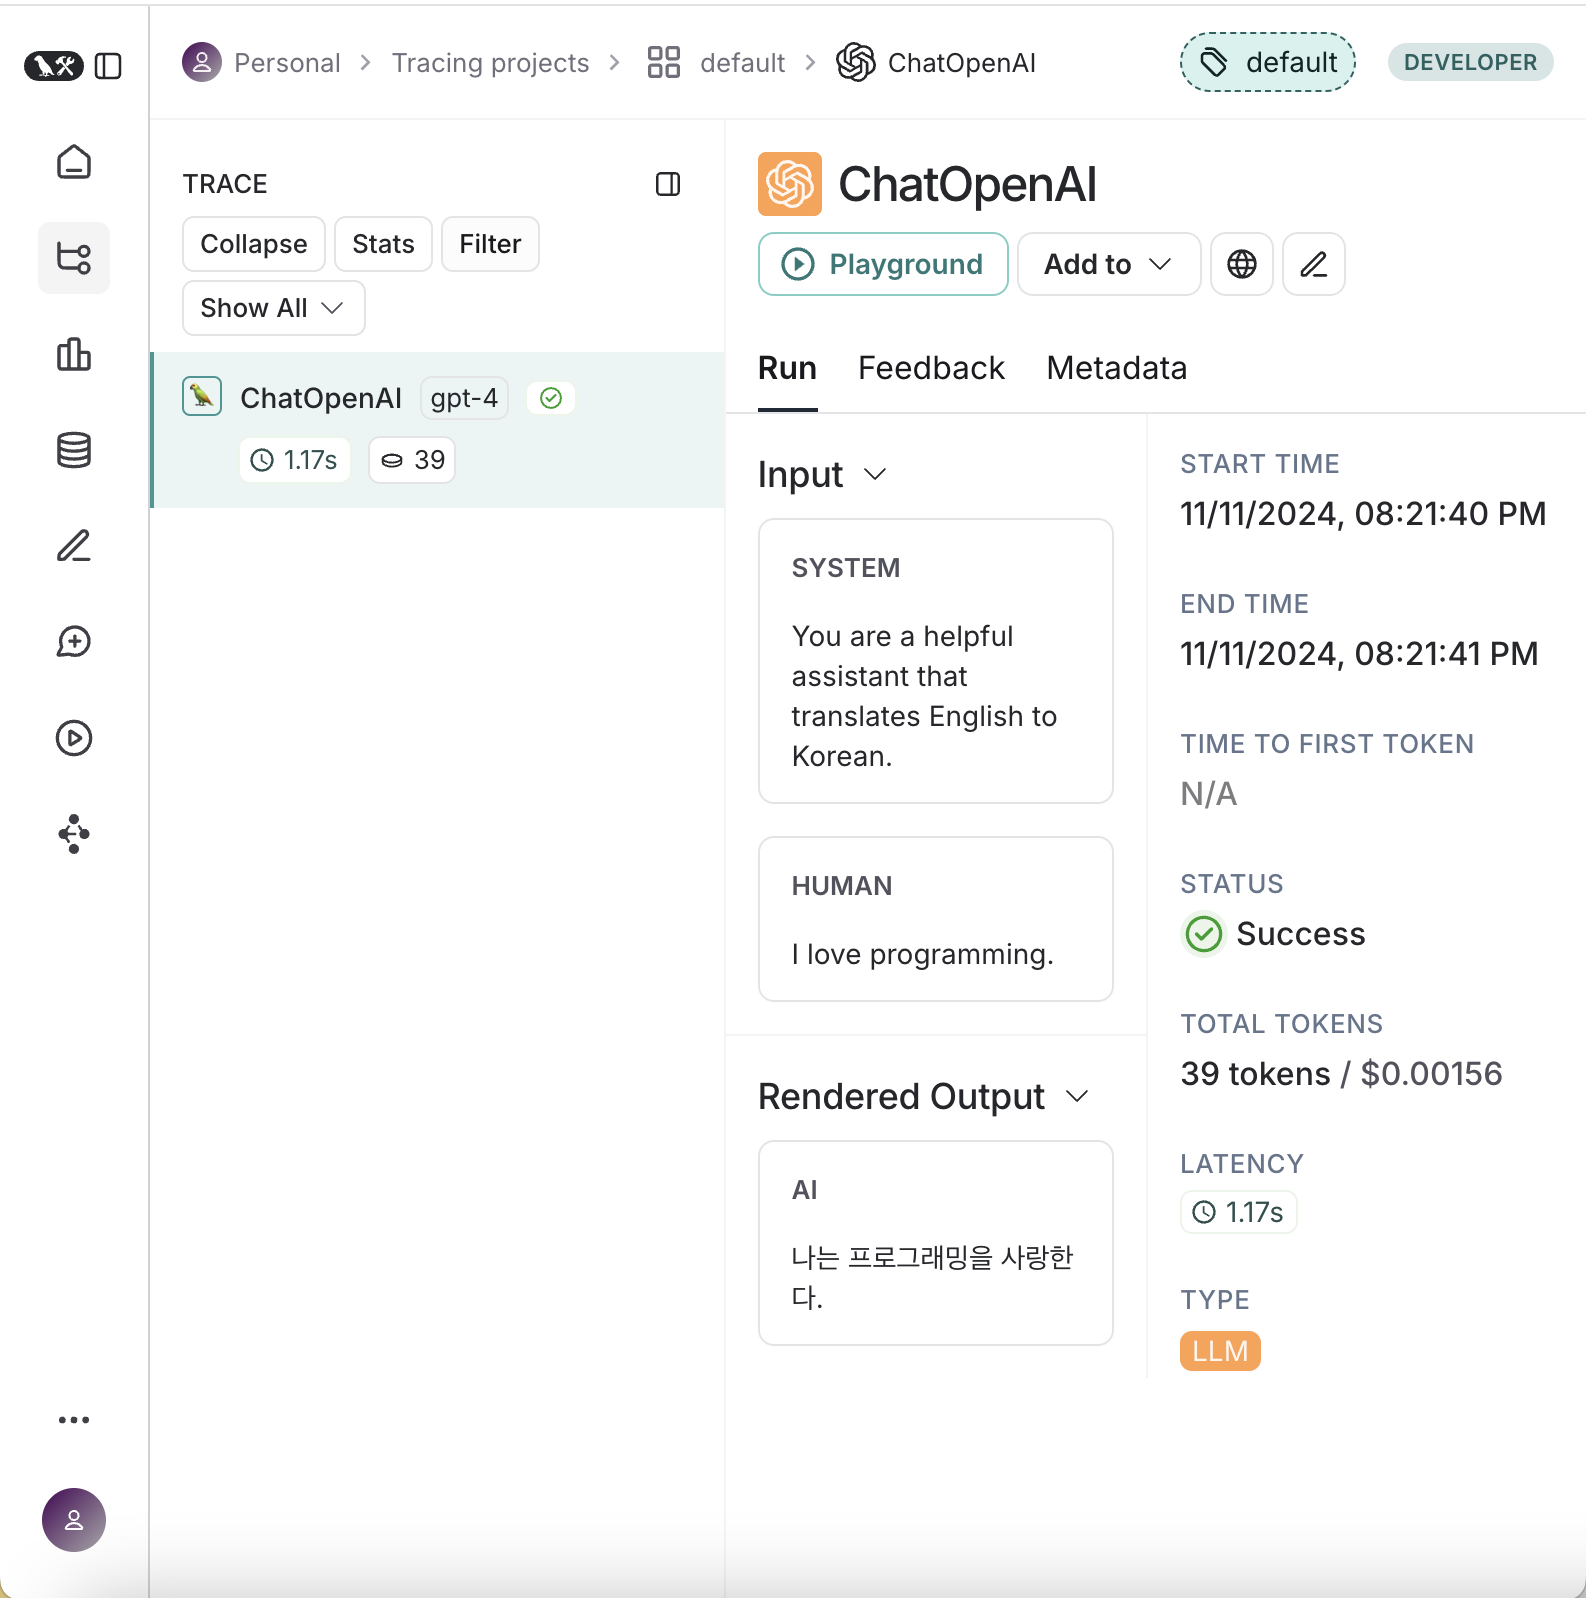)

## OutputParsers
`AIMessage`는 모델의 응답으로, 방금 전 보았던 출력처럼 string과 응답에 대한 메타데이터를 포함한다.
우리가 문자열 형태로만 응답을 얻고 싶다면 출력 파서를 사용해야 한다.

- LLM의 출력을 받아 더 적합한 형식으로 변환
- 구조화된 데이터 생성에 매우 유용함
- LangChain 프레임워크에서 다양한 종류의 출력 데이터를 파싱하고 처리

**주요 특징**

다양성, 스트리밍 지원, 확장성

In [ ]:
from langchain_core.output_parsers import StrOutputParser

parser = StrOutputParser()

In [ ]:
result = model.invoke(msgs)

In [ ]:
parser.invoke(result)

'나는 프로그래밍을 사랑한다.'

### Chain 생성
invoke할 때마다 parser를 사용하는 대신 `|` 을 사용해서 모델의 응답과 parser를 연결할 수 있다.
이 연결을 통해 chain을 호출할 때마다 우리가 선언한 출력 parser를 사용할 수 있게 된다.

In [ ]:
chain = model | parser
chain.invoke(msgs)

'나는 프로그래밍을 사랑한다.'

## Prompt Templates
프롬프트 템플릿은 사용자의 입력값을 언어 모델에 전달될 수 있는 형태로 포맷팅한다.


In [ ]:
from langchain_core.prompts import ChatPromptTemplate

system_template이 모델에게 내리는 일종의 명령이 된다.

In [ ]:
system_template = "Translate the following into {language}:"

In [ ]:
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)

`prompt_template`의 입력은 dictionary 형태이다. invoke하면 `ChatPromptValue`를 반환하는데, 이때 SystemMessage content의 {language}가 korean이 된 걸 확인할 수 있다.

In [ ]:
result = prompt_template.invoke({"language": "korean", "text": "hi"})
#ChatPromptValue 객체 반환
result

ChatPromptValue(messages=[SystemMessage(content='Translate the following into korean:', additional_kwargs={}, response_metadata={}), HumanMessage(content='hi', additional_kwargs={}, response_metadata={})])

In [ ]:
result.to_messages() #메시지에 직접 액세스

[SystemMessage(content='Translate the following into korean:', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='hi', additional_kwargs={}, response_metadata={})]

`|` 연산자를 사용해서 모델과 출력파서를 결합할 수 있다.

In [ ]:
chain = prompt_template | model | parser

In [ ]:
chain.invoke({"language": "korean", "text": "hi"})

'안녕하세요'

## LangServe로 모델 서빙하기
1. 체인 정의
2. FastAPI 앱
3. langserve.add_routes에 chain을 서비스할 경로가 정의된다.


In [ ]:
%pip install langserve



```
#!/usr/bin/env python
from dotenv import load_dotenv
from fastapi import FastAPI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langserve import add_routes

#API KEY
load_dotenv()

# 1. Create prompt template
system_template = "Translate the following into {language}:"
prompt_template = ChatPromptTemplate.from_messages([
    ('system', system_template),
    ('user', '{text}')
])

# 2. Create model
model = ChatOpenAI()

# 3. Create parser
parser = StrOutputParser()

# 4. Create chain
chain = prompt_template | model | parser

# 5. App definition
app = FastAPI(
  title="LangChain Server",
  version="1.0",
  description="A simple API server using LangChain's Runnable interfaces",
)

# 6. Adding chain route
add_routes(
    app,
    chain,
    path="/chain",
)

if __name__ == "__main__":
    import uvicorn

    uvicorn.run(app, host="localhost", port=8000)
```



**실행 화면**

LangServe는 간단한 UI를 가진 Playground를 제공한다. 서버를 실행하고 Inputs에 번역할 텍스트와 language를 입력하면 번역 결과가 나온다.

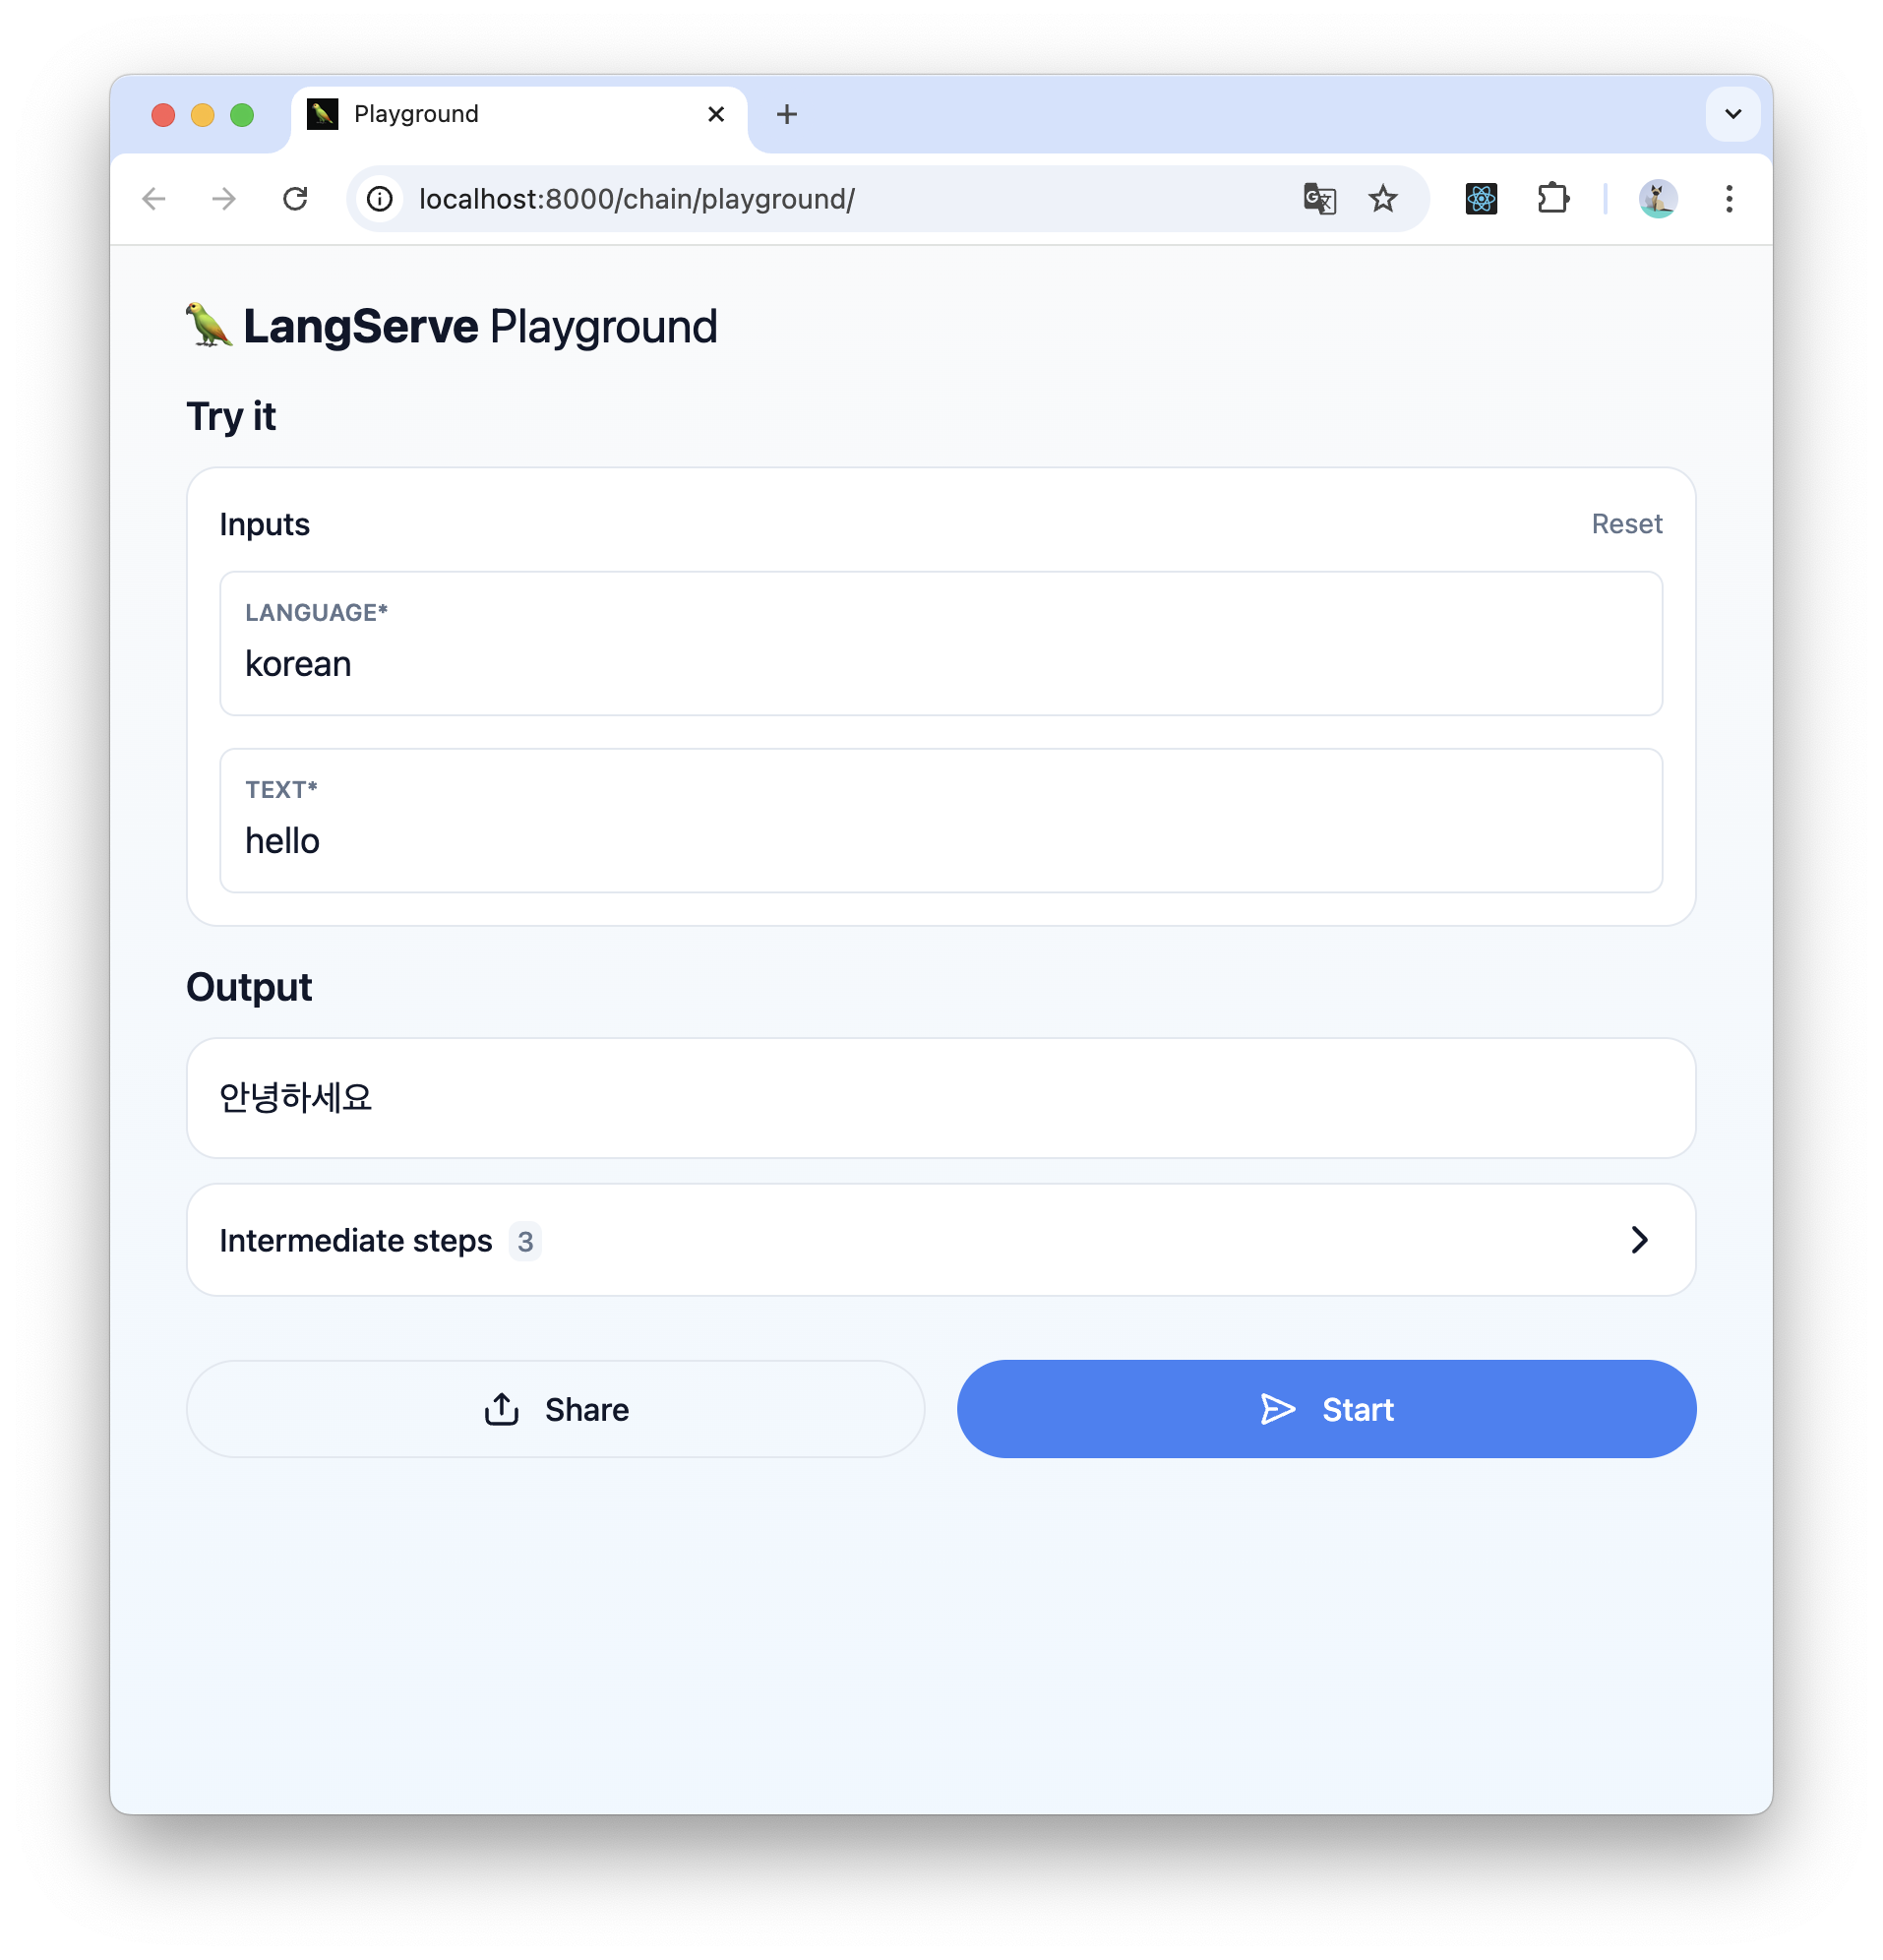

### RemoteRunnable
> 특정 작업을 원격 서버에서 실행하고, 그 결과를 가져오기 위한 도구나 인터페이스.



In [ ]:
from langserve import RemoteRunnable

remote_chain = RemoteRunnable("http://localhost:8000/chain/")
remote_chain.invoke({"language": "korean", "text": "hello world!"})

'안녕하세요 세상아!'